# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация. 

### Общая информация
Дата выдачи: 20.10.2020

Мягкий дедлайн: 01:59MSK 02.11.2020 (за каждый день просрочки снимается 1 балл)

Жесткий дедлайн: 01:59MSK 05.11.2020

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.


### Формат сдачи
Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-classification-Username.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-classification-IvanovIvan.ipynb).

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: 9.9 + 2.01

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

# Часть 0. SVM, LR и калибровка вероятностей. 

Сгенерируем синтетические данные.

In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

__Задание 1.__ Обучение и применение метода опорных векторов и логистической регрессии.

__(1 балл)__

Обучите метод опорных векторов. На занятиях мы проходили линейный вариант без ядрового перехода, что соответствует линейному ядру (`LinearSVC` или же `SVC(kernel='linear')` в `sklearn.svm`). Подберите параметр регуляризации `C` (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей). 

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

svc_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('svc', LinearSVC(dual=False))
])
reg_Cs = np.logspace(-2, 3, 20)
linear_svc = GridSearchCV(svc_pipeline, {"svc__C": reg_Cs}, cv=10)    # chooses best by score estimate
model = linear_svc.fit(X_train, y_train)

In [4]:
print('Best parameter C: %.4f' % linear_svc.best_params_['svc__C'])
best_model_svc = linear_svc.best_estimator_
print('Train score: %.4f' % best_model_svc[1].score(X_train, y_train))    # score - mean accuracy
print('Test score: %.4f' % best_model_svc[1].score(X_test, y_test))

Best parameter C: 0.0336
Train score: 0.7600
Test score: 0.7493


На тестовой части посчитайте AUC-ROC, AUC-PR с точностью до 5 знаков. Постройте ROC и PR кривые, сравните их с ответами случайного классификатора. Заметим, что с помощью `sklearn` можно посчитать обе метрики двумя разными способами - в чем их различия? Сравните результаты. 

*Получим сначала кривую, потом посчитаем с помощью `metrics.auc` площади под кривыми:*

In [6]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
dummy_preds = np.random.normal(0,1,X_test.shape[0])
fpr_dummy, tpr_dummy, roc_thresholds_dummy = roc_curve(y_test, dummy_preds)
precision_dummy, recall_dummy, pr_thresholds_dummy = precision_recall_curve(y_test, dummy_preds)
auc_roc_dummy = auc(fpr_dummy, tpr_dummy)
auc_pr_dummy = auc(recall_dummy, precision_dummy)
print('Random classification')
print('AUC-ROC: %.5f' % auc_roc_dummy)
print('AUC-PR: %.5f' % auc_pr_dummy)

Random classification
AUC-ROC: 0.50007
AUC-PR: 0.51888


In [7]:
b_pred_svc = best_model_svc.decision_function(X_test)
fpr_svc, tpr_svc, roc_thresholds_svc = roc_curve(y_test, b_pred_svc)
precision_svc, recall_svc, pr_thresholds_svc = precision_recall_curve(y_test, b_pred_svc)
auc_roc_svc = auc(fpr_svc, tpr_svc)
auc_pr_svc = auc(recall_svc, precision_svc)
print('SVC')
print('AUC-ROC: %.5f' % auc_roc_svc)
print('AUC-PR: %.5f' % auc_pr_svc)

SVC
AUC-ROC: 0.84762
AUC-PR: 0.82966


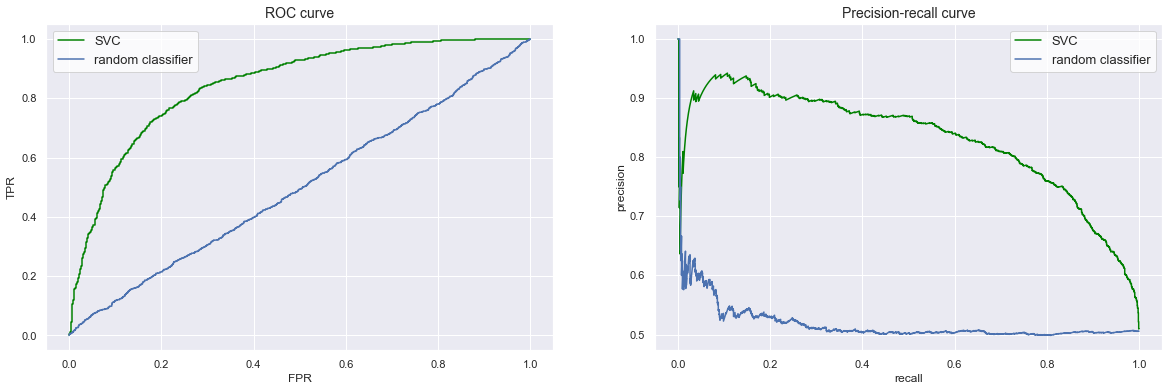

In [8]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1.plot(fpr_svc, tpr_svc, color='green', label='SVC')
ax1.set_title('ROC curve', size=14)
ax1.set(xlabel='FPR', ylabel='TPR')
ax1.plot(fpr_dummy, tpr_dummy, color='b', label='random classifier')
ax2 = plt.subplot(122)
ax2.set_title('Precision-recall curve', size=14)
ax2.set(xlabel='recall', ylabel='precision')
ax2.plot(recall_svc, precision_svc, color='green', label='SVC')
ax2.plot(recall_dummy, precision_dummy, color='b', label='random classifier')
ax1.legend(facecolor='w',fontsize=13)
ax2.legend(facecolor='w',fontsize=13)
plt.show()

*Второй вариант: посчитаем метрики готовыми функциями в `sklearn`:*

In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score

auc_roc_svc_ = roc_auc_score(y_test, b_pred_svc)
auc_pr_svc_ = average_precision_score(y_test, b_pred_svc)
print('SVC')
print('AUC-ROC: %.5f' % auc_roc_svc_)
print('AUC-PR: %.5f' % auc_pr_svc_)

SVC
AUC-ROC: 0.84762
AUC-PR: 0.82992


*В первом случае площадь считается с помощью метода трапеций (домножение на усреднённое значение функции на границах отрезка), во втором подсчитывается правая сумма Римана ($AP = \sum\limits_{n}(R_n - R_{n-1})P_n$) Результаты отличаются только для precision-recall curve: во втором случае получено большее значение.* 

*По сравнению со случайным классификатором видим, что кривые для метода опорных векторов получаются лучше - в случайном случае ROC-кривая проходит по диагонали, значения precision меньше.*

А теперь проделайте все то же самое для логистической регрессии (LR) — обучение, подбор параметра регуляризации (используйте L2-регуляризацию), вычисление всех метрик и построение кривых. Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).

In [10]:
from sklearn.linear_model import LogisticRegression

lr_pipeline = Pipeline([
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2'))
])
reg_Cs = np.logspace(-2, 3, 20)
lr = GridSearchCV(lr_pipeline, {"lr__C": reg_Cs}, cv=10)    # chooses best by score estimate
lr_model = lr.fit(X_train, y_train)

In [11]:
print('Best parameter C: %.4f' % lr.best_params_['lr__C'])
best_model_lr = lr.best_estimator_
print('Train score: %.4f' % best_model_lr[1].score(X_train, y_train))
print('Test score: %.4f' % best_model_lr[1].score(X_test, y_test))

Best parameter C: 0.0336
Train score: 0.7593
Test score: 0.7487


In [12]:
b_pred_lr = best_model_lr.decision_function(X_test)
fpr_lr, tpr_lr, roc_thresholds_lr = roc_curve(y_test, b_pred_lr)
precision_lr, recall_lr, pr_thresholds_lr = precision_recall_curve(y_test, b_pred_lr)
auc_roc_lr = auc(fpr_lr, tpr_lr)
auc_pr_lr = auc(recall_lr, precision_lr)
print('Logistic regression')
print('AUC-ROC: %.5f' % auc_roc_lr)
print('AUC-PR: %.5f' % auc_pr_lr)

Logistic regression
AUC-ROC: 0.84768
AUC-PR: 0.82934


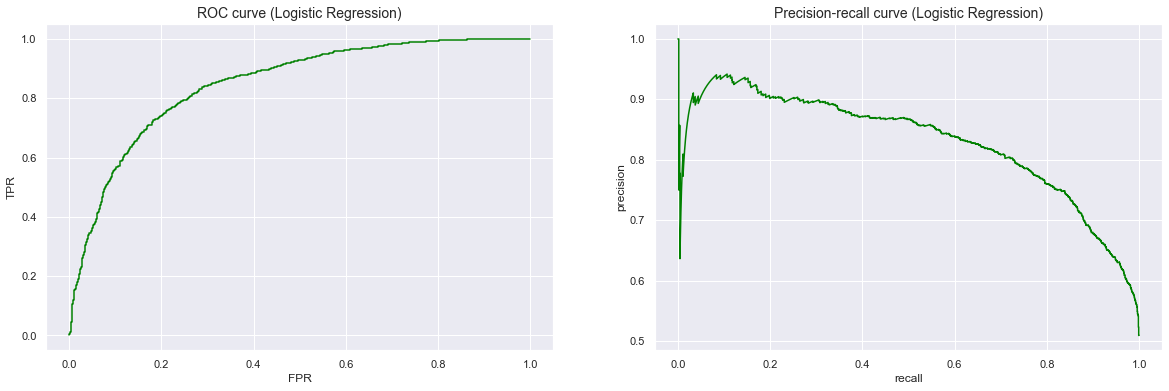

In [13]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1.plot(fpr_lr, tpr_lr, color='green')
ax1.set_title('ROC curve (Logistic Regression)', size=14)
ax1.set(xlabel='FPR', ylabel='TPR')
ax2 = plt.subplot(122)
ax2.set_title('Precision-recall curve (Logistic Regression)', size=14)
ax2.set(xlabel='recall', ylabel='precision')
ax2.plot(recall_lr, precision_lr, color='green')
plt.show()

*Второй вариант: посчитаем метрики готовыми функциями в `sklearn`:*

In [14]:
auc_roc_lr_ = roc_auc_score(y_test, b_pred_lr)
auc_pr_lr_ = average_precision_score(y_test, b_pred_lr)
print('Logistic regression')
print('AUC-ROC: %.5f' % auc_roc_lr_)
print('AUC-PR: %.5f' % auc_pr_lr_)

Logistic regression
AUC-ROC: 0.84768
AUC-PR: 0.82960


*Для логистической регрессии значения AUC-ROC получились больше, чем для метода опорных векторов, тогда как значения PR-ROC получились меньше. Объяснить это можно тем, что метод опорных векторов находит гиперплоскость, наиболее точно разделяющую объекты на классы. Поэтому для неё AUC-ROC выходит больше (TPR ближе к единице). Логистическая регрессия же приближает правдоподобие положительных ответов (и при этом может находить разделяющие плоскости, которые дают более плохой результат AUC-ROC), из-за чего AUC-PR у него лучше, чем у метода опорных векторов.*

В названии метода опорных векторов присутствуют некоторые "опорные векторы". Сгенерируйте синтетический датасет с помощью `make_classification` с 2 признаками, обучите на нём метод опорных векторов. Визуализируйте разделяющую прямую, все объекты и выделите опорные вектора (атрибут `support_vectors_`). В этот раз, если необходимо, вместо `LinearSVC` воспользуйтесь `SVC(kernel='linear')`, так как только в нём есть информация об опорных векторах.

In [15]:
X_1, y_1 = make_classification(n_samples = 2000, n_features=2, n_informative=2, n_redundant=0, 
                               n_clusters_per_class=1, random_state=88)

In [16]:
from sklearn.svm import SVC
svc_pipeline_1 = Pipeline([
    ('scaling', StandardScaler()),
    ('svc', SVC(kernel='linear', probability=True))
])
reg_Cs = np.logspace(-2, 3, 20)
svc_1 = GridSearchCV(svc_pipeline_1, {"svc__C": reg_Cs}, cv=5)
model = svc_1.fit(X_1, y_1)

In [17]:
print('Best parameter C: %.4f' % svc_1.best_params_['svc__C'])
best_model_svc_1 = svc_1.best_estimator_
print('Score: %.4f' % best_model_svc_1[1].score(X_1, y_1))

Best parameter C: 0.3793
Score: 0.9925


[Plotting SVC Decision Function](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html)

In [18]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    w = model.coef_[0]
    xx = np.linspace(xlim[0], xlim[1])
    yy = (-w[0] * xx - model.intercept_[0]) / w[1]    # hyperplane: <w,x> + b = 0 <=> x_2 = (-w_1 * x_1 - b) / w_2
    ax.plot(xx, yy, 'k-', color='midnightblue')

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=80, linewidth=1, facecolors='none', edgecolor='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

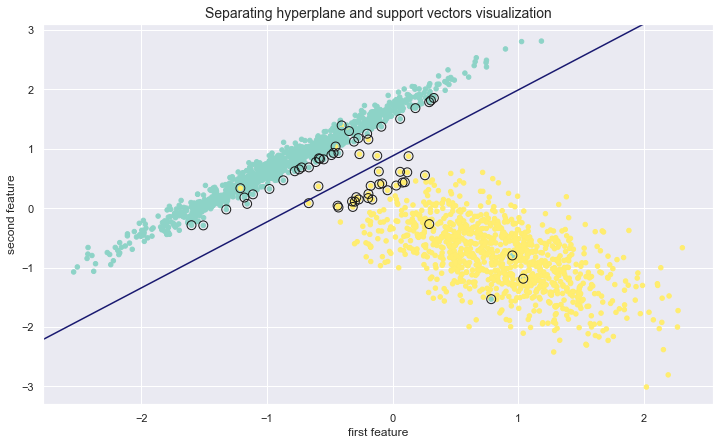

In [19]:
plt.figure(figsize=(12,7))
plt.xlabel('first feature')
plt.ylabel('second feature')
plt.title('Separating hyperplane and support vectors visualization', size=14)
plt.scatter(svc_pipeline_1[0].fit_transform(X_1)[:, 0], svc_pipeline_1[0].fit_transform(X_1)[:, 1], c=y_1, s=20, cmap='Set3')
plot_svc_decision_function(best_model_svc_1[1])

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость, а приближает в каждой точке пространства объектов правдоподобие положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты. Вам может помочь функция `plt.pcolor`.

[sklearn: classification probability plot](https://scikit-learn.org/0.15/auto_examples/plot_classification_probability.html)

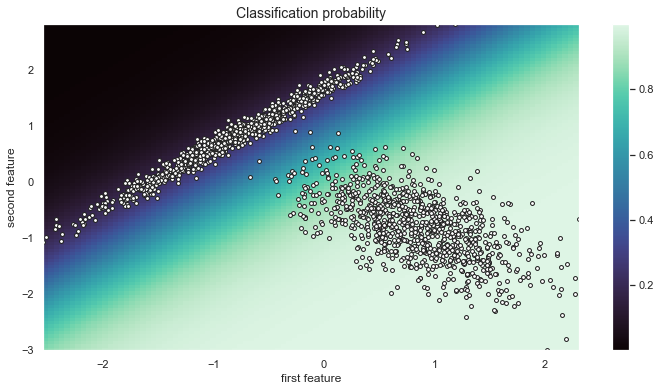

In [20]:
fig = plt.figure(figsize=(12,6))

xx = np.linspace(X_1[:,0].min(), X_1[:,0].max(), 100)
yy = np.linspace(X_1[:,1].min(), X_1[:,1].max(), 100)
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]
Z = 1 / (1 + np.exp(-best_model_svc_1.decision_function(Xfull)))    # sigmoid = 1 / (1 + exp(-(<w,x> + b)))

X_1_tf = svc_pipeline_1[0].fit_transform(X_1)
xx = np.linspace(X_1_tf[:,0].min(), X_1_tf[:,0].max(), 100)
yy = np.linspace(X_1_tf[:,1].min(), X_1_tf[:,1].max(), 100)
xx, yy = np.meshgrid(xx, yy)
c = plt.pcolor(xx, yy, Z.reshape(100,100), cmap='mako')
fig.colorbar(c)
plt.scatter(X_1_tf[:,0], X_1_tf[:,1], s=15, color='w', edgecolor='k')

plt.title('Classification probability', size=14)
plt.xlabel('first feature', size=12)
plt.ylabel('second feature', size=12)
plt.show()

__Задание 2.__ Калибровка вероятностей.

__(1 балл)__

Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых. 

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность? Для этого разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины. Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной. Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [21]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append(l + (r - l) / 2)    # changed l - r
        bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)]))    # changed np.min(y_test[(preds >= l) & (preds < r)] == 1)
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    
    # added title and axis labels
    plt.title('Calibration curve', size=13)
    plt.xlabel('probability')
    plt.ylabel('positive rate')
    #plt.grid()

Сгенерируйте синтетический датасет аналогично использованному в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$). Изучите распределение ответов классификаторов (постройте гистограммы с помощью `plt.hist`). Чем они различаются? Чем вы можете объяснить это?

In [22]:
X_2, y_2 = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5,
    random_state=42)

X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(
    X_2, y_2, test_size=0.3, random_state=42)

In [23]:
# SVC with best parameter from the first task
svc_pipe_2 = Pipeline([
    ('scaling', StandardScaler()),
    ('svc', LinearSVC(dual=False, C=linear_svc.best_params_['svc__C']))    # param C from 1st task
])
model = svc_pipe_2.fit(X_2_train, y_2_train)

# Logistic regression with best parameter from the first task
lr_pipe_2 = Pipeline([
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', C=lr.best_params_['lr__C']))    # param C from 1st task
])
model = lr_pipe_2.fit(X_2_train, y_2_train)

[sklearn: calibration curve, probability without predict_proba](https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py)

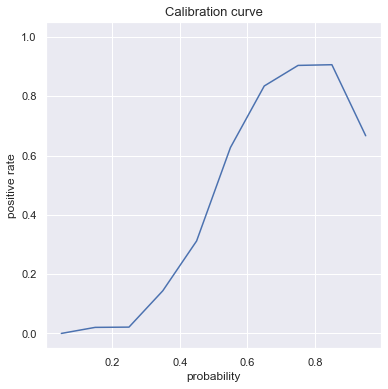

In [24]:
svc_preds = svc_pipe_2.decision_function(X_test)
svc_preds = (svc_preds - svc_preds.min()) / (svc_preds.max() - svc_preds.min())
plot_calibration_curve(y_2_test, svc_preds)

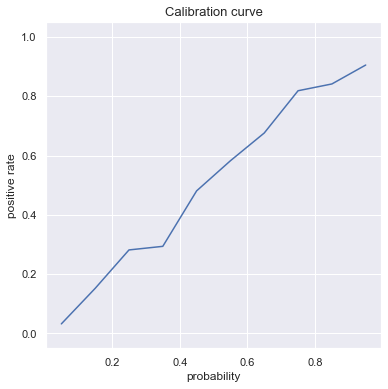

In [27]:
lr_decs = lr_pipe_2.decision_function(X_2_test)
lr_preds = lr_pipe_2.predict_proba(X_2_test)[:,1]
plot_calibration_curve(y_2_test, lr_preds)
plt.show()

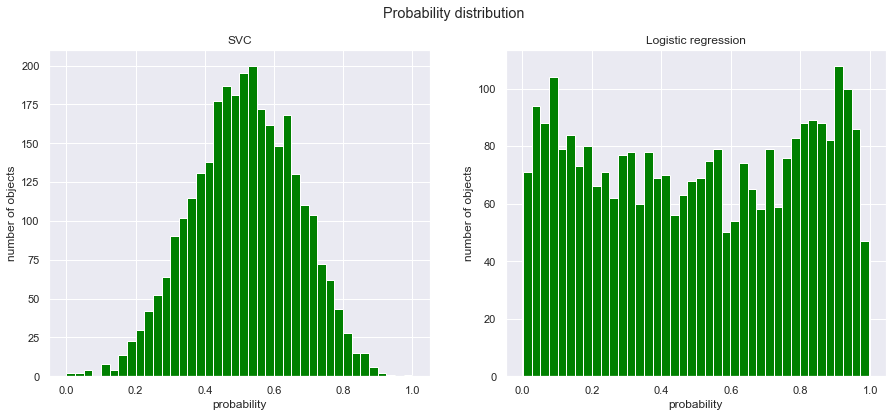

In [28]:
plt.figure(figsize=(15,6))
plt.suptitle('Probability distribution')
ax1 = plt.subplot(121)
ax1.hist(svc_preds, bins=40, color='green')
ax1.set(ylabel='number of objects', xlabel='probability')
ax1.set_title('SVC')
ax2 = plt.subplot(122)
ax2.set_title('Logistic regression')
ax2.hist(lr_preds, bins=40, color='green')
ax2.set(ylabel='number of objects', xlabel='probability')
plt.show()

*Для метода опорных векторов можно заметить, что объекты разделены так, что большинство из них имеют вероятность попадания в положительный класс равной 0.5. Это значит, что для большинства объектов точность определения класса невелика (скорее всего из-за того, что большинство точек находится близко к разделяющей гиперплоскости). Поскольку логистическая регрессия приближает в каждой точке правдоподобие положительных ответов, распределение вероятностей становится более равномерным, что наблюдаем на графике.*

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью предсказания для тестовой выборки. Нарисуйте для них калибровочную кривую. Улучшилась ли она?

In [29]:
from sklearn.calibration import CalibratedClassifierCV
clf_cv = CalibratedClassifierCV(svc_pipe_2, method='sigmoid', cv=3)
model = clf_cv.fit(X_2_train, y_2_train)
cv_pred_proba = clf_cv.predict_proba(X_2_test)[:,1]

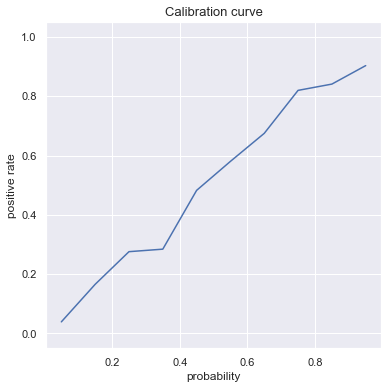

In [32]:
plot_calibration_curve(y_2_test, cv_pred_proba)

In [33]:
print('Test score before calibration: %.4f' % svc_pipe_2.score(X_2_test, y_2_test))
print('Test score after calibration: %.4f' % clf_cv.score(X_2_test, y_2_test))

Test score before calibration: 0.7717
Test score after calibration: 0.7720


*Калибровочная кривая стала ближе к диагональной, качество модели после калибровки немного улучшилось.*

__Бонусное задание (0.5 балла).__ Реализуйте свою функцию для калибровки вероятностей. Опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

*Проделаем калибровку Платта. Для этого на отложенной выборке по полученным прогнозам подберём такие параметры $\alpha$ и $\beta$, что:*
$$logloss = -(y_{true}\cdot\log(\hat{b}(x) + (1 - y_{true})\cdot\log(1-\hat{b}(x))) \rightarrow \min\limits_{\alpha, \beta},$$
$$\hat{b}(x) = \frac{1}{1 + \exp(-\alpha \cdot b(x) - \beta)}$$

In [164]:
from sklearn.metrics import log_loss
class PlattCalibration (BaseEstimator, TransformerMixin):
    def __init__(self, preds):
        self.probA = np.logspace(-2,1,5)
        self.probB = np.logspace(-2,1,5)
        self.bestA = None
        self.bestB = None
        self.preds = preds
        self.calibrated_preds = None
    
    def fit(self, X, y):
        min_log_loss = 100
        
        for a in self.probA:
            for b in self.probB:
                new_preds = 1 / (1 + np.exp(-a * self.preds - b))    # choosing a and b as argmin of logloss
                cur_log_loss = log_loss(y, new_preds)
                if cur_log_loss < min_log_loss:
                    min_log_loss = cur_log_loss
                    self.bestA = a
                    self.bestB = b
                    self.calibrated_preds = new_preds
        return self
    
    def transform(self, X):
        return X
    
    def new_preds(self, preds):
        return 1 / (1 + np.exp(-self.bestA * preds - self.bestB))

In [165]:
svc_pipe_2_ = Pipeline([
    ('scaling', StandardScaler()),
    ('svc', LinearSVC(dual=False, C=linear_svc.best_params_['svc__C']))    # param C from 1st task
])
svc_pipe_2_.fit(X_2_train, y_2_train)

X_val__, X_test__, y_val__, y_test__ = train_test_split(    # fit on part of train set
    X_2_train, y_2_train, test_size=0.3, random_state=42)

val_preds = svc_pipe_2_.decision_function(X_val__)
test_preds = svc_pipe_2_.decision_function(X_2_test)

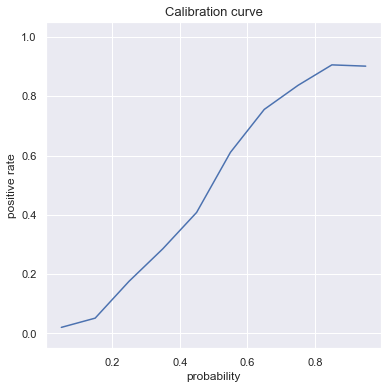

In [166]:
platt_cal = PlattCalibration(val_preds)
platt_cal.fit(X_val__, y_val__)
plot_calibration_curve(y_2_test, platt_cal.new_preds(test_preds))    # calibrate predictions of test set

*Как можно увидеть по графику, калибровочная кривая стала более прямой и ближе к диагональной.*

# Часть 1. Работа с переменными.

В этой части мы научимся обрабатывать категориальные переменные, так как закодировать их в виде чисел недостаточно (это задаёт некоторый порядок, которого на категориальных переменных может и не быть). Существует два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

__Подготовка данных.__

Загрузим данные [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге, объектом в нем является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит), целевой переменной - ответ клиента (согласился ли он открыть депозит?). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.

In [35]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
#!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [36]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


__Задание 3 (0.5 балла).__ Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify`. Один из столбцов в данных не несет информации для решения задачи — какой? Отбросьте его. 



*Лишний столбец - `duration`, поскольку признак продолжительности звонка нельзя использовать при построении модели - при новом звонке его продолжительность заранее неизвестна, а при окончании звонка значение целевой переменной известно.*

In [37]:
y_3 = df.y
X_3 = df.drop(columns=['y', 'duration'])
X_3_train, X_3_test, y_3_train, y_3_test = train_test_split(X_3, y_3, test_size=0.25, random_state=777, stratify=y_3)

In [38]:
# from bank-additional-names.txt
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c `AUC-PR`) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели (с учетом кодирования признаков).

__Вопрос__: почему в данном задании мы выбрали метрикой именно `AUC-PR`, а не, к примеру, `AUC-ROC`?

__Ваш ответ__: *По заданию положительный класс более важен, чем отрицательный, в том смысле, что компанию больше интересует случай, когда клиент соглашается открыть депозит. ROC-кривая, в отличие от precision-recall-кривой, не зависит от распределения p(y = 1), а эта вероятность как раз важна в данной задаче.*

In [39]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

column_transformer = ColumnTransformer([
    ('ordenc', OrdinalEncoder(), categorical)
])

lr_pipeline_2 = Pipeline([
    ('col', column_transformer),
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2'))
])

In [40]:
# Logistic regression
reg_Cs = np.logspace(-2, 3, 20)
lr_3 = GridSearchCV(lr_pipeline_2, {"lr__C": reg_Cs}, cv=5)
model = lr_3.fit(X_3_train, y_3_train)

print('Best parameter C: %.4f' % lr_3.best_params_['lr__C'])
best_lr_model_3 = lr_3.best_estimator_
b_train_preds_3 = best_lr_model_3.decision_function(X_3_train)
print('Train AUC-PR: %.4f' % average_precision_score(y_3_train, b_train_preds_3, pos_label='yes'))
b_preds_3 = best_lr_model_3.decision_function(X_3_test)
print('Test AUC-PR: %.4f' % average_precision_score(y_3_test, b_preds_3, pos_label='yes'))

Best parameter C: 0.2069
Train AUC-PR: 0.2916
Test AUC-PR: 0.3072


*OrdinalEncoder fitting time:*

In [41]:
%%timeit
best_lr_model_3.fit(X_3_train, y_3_train)

218 ms ± 15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


__Задание 4 (0.5 балла).__ Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.



In [42]:
from sklearn.preprocessing import OneHotEncoder
column_transformer_4 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numerical)
])

lr_pipeline_4 = Pipeline([
    ('col', column_transformer_4),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [43]:
# Logistic regression
reg_Cs = np.logspace(-2, 3, 20)
lr_4 = GridSearchCV(lr_pipeline_4, {"lr__C": reg_Cs}, cv=5)
model = lr_4.fit(X_3_train, y_3_train)

print('Best parameter C: %.4f' % lr_4.best_params_['lr__C'])
best_lr_model_4 = lr_4.best_estimator_

b_train_preds_4 = best_lr_model_4.decision_function(X_3_train)
print('Train AUC-PR: %.4f' % average_precision_score(y_3_train, b_train_preds_4, pos_label='yes'))
b_preds_4 = best_lr_model_4.decision_function(X_3_test)
print('Test AUC-PR: %.4f' % average_precision_score(y_3_test, b_preds_4, pos_label='yes'))

Best parameter C: 0.0336
Train AUC-PR: 0.4549
Test AUC-PR: 0.4486


*Качество модели улучшилось, относительно качества при `OrdinalEncoder` примерно в 1.5 раза.*

*OneHotEncoder fitting time:*

In [44]:
%%timeit
best_lr_model_4.fit(X_3_train, y_3_train)

505 ms ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Как можно было заметить, one-hot-кодирование может сильно увеличивать количество признаков в датасете, что сказывается на памяти, особенно, если некоторый признак имеет большое количество значений. Эту проблему решает другой способ кодирования категориальных признаков — счётчики. Основная идея в том, что нам важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:
$$
g_j(x, X) = \frac{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{l} [f_j(x) = f_j(x_i)]}
$$

__Задание 5 (1 балл).__ Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве. Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков). Заметили ли вы что-то интересное?


__Бонус (1 балл)__: Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их. 


In [45]:
# COMPILE ONCE ONLY
# to prevent warning
X_3_train = X_3_train.copy()
X_3_test = X_3_test.copy()
y_3_train = y_3_train.copy()
y_3_test = y_3_test.copy()

# transform target into binary
y_3_train = 1 * (y_3_train == 'yes')
y_3_test = 1 * (y_3_test == 'yes')

In [46]:
from sklearn.base import BaseEstimator, TransformerMixin
from collections import defaultdict
class CountEncoder (BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.new_values = defaultdict(list)
        self.columns = columns
        
    def fit(self, X, y):
        X_copy = X.copy()
        for col in self.columns:
            self.new_values[col] = defaultdict()
            for value in X_copy[col].unique():
                self.new_values[col][value] = np.mean(y[X_copy[col] == value])    # for each value in category get its mean target
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy.loc[:,'count_'+col] = X_copy[col].copy()
            for value in X_copy[col].unique():
                if not (value in self.new_values[col]):
                    X_copy.loc[X_copy[col] == value, 'count_' + col] = 0.5    # if value was not present in fit
                else:
                    X_copy.loc[X_copy[col] == value, 'count_' + col] = self.new_values[col][value]
        
        X_copy.drop(columns=self.columns, inplace=True)
        return X_copy
    
    def new_values(self):
        return self.new_values

In [47]:
lr_pipeline_5_ = Pipeline([
    ('cntenc', CountEncoder(categorical)),
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [48]:
# Logistic regression
reg_Cs = np.logspace(-2, 3, 20)
lr_5_ = GridSearchCV(lr_pipeline_5_, {"lr__C": reg_Cs}, cv=5)
model = lr_5_.fit(X_3_train, y_3_train)

In [49]:
print('Best parameter C: %.4f' % lr_5_.best_params_['lr__C'])
best_lr_model_5_ = lr_5_.best_estimator_

b_train_preds_5_ = best_lr_model_5_.decision_function(X_3_train)
print('Train AUC-PR: %.4f' % average_precision_score(y_3_train, b_train_preds_5_))
b_preds_5_ = best_lr_model_5_.decision_function(X_3_test)
print('Test AUC-PR: %.4f' % average_precision_score(y_3_test, b_preds_5_))

Best parameter C: 14.3845
Train AUC-PR: 0.4439
Test AUC-PR: 0.4430


*CountEncoder fitting time:*

In [50]:
%%timeit
best_lr_model_5_.fit(X_3_train, y_3_train)

796 ms ± 35.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Вывод:** *Самое быстрое время обучения при использовании `OrdinalEncoder` ~ 0.2s, при использовании `OneHotEncoder` время увеличивается до 0.5s, при использовании счётчика - время обучения равно ~0.8s (чуть больше при реализации трансформера). При использовании `OrdinalEncoder` значение метрики AUC-PR получилось небольшим - 0.3072 (из кодирования категориальных признаков числами не получаем значимую информацию). При использовании `OneHotEncoder` и `CountEncoder` AUC-PR получились больше - 0.449 и 0.443 соответственно. Заметим, что при использовании счётчиков значение метрики на тестовой выборке чуть хуже, чем при one-hot-кодировании, возможно, при обучении с счётчиками модель подстраивается под обучающую выборку, из-за чего качество на тестовой выборке ухудшается.*

Отметим, что такие признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к переобучению, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его целевая метка не использовалась. Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки. 

__Задание 6.__ Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям (постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков). Снова обучите логистическую регрессию, оцените качество. Сделайте выводы.

__(0.5 балла)__

In [51]:
class CountEncoderWithNoise (BaseEstimator, TransformerMixin):
    def __init__(self, columns, std_dev=1):
        self.new_values = defaultdict(list)
        self.columns = columns
        self.std_dev = std_dev    # hyperparameter: standard deviation for noise
        
    def fit(self, X, y):
        X_copy = X.copy()
        for col in self.columns:
            self.new_values[col] = defaultdict()
            for value in X_copy[col].unique():
                self.new_values[col][value] = np.mean(y[X_copy[col] == value])    # for each value in category get its mean target
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy.loc[:,'count_' + col] = X_copy[col].copy()
            for value in X_copy[col].unique():
                if not (value in self.new_values[col]):
                    X_copy.loc[X_copy[col] == value, 'count_'+col] = 0.5    # if value was not present in fit
                else:
                    X_copy.loc[X_copy[col] == value, 'count_'+col] = self.new_values[col][value]
            X_copy.loc[:,'count_' + col] += np.random.normal(0, self.std_dev, X_copy.shape[0])    # add noise
        
        X_copy.drop(columns=self.columns, inplace=True)
        return X_copy
    
    def new_values(self):
        return self.new_values

In [52]:
lr_pipeline_6 = Pipeline([
    ('cntenc', CountEncoderWithNoise(categorical)),
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [53]:
noise_devs = np.logspace(-2, 3, 5)
reg_Cs = np.logspace(-2, 3, 20)
lr_6 = GridSearchCV(lr_pipeline_6, {"cntenc__std_dev": noise_devs, "lr__C":reg_Cs}, cv=3)
model = lr_6.fit(X_3_train, y_3_train)

In [54]:
print('Best parameters: C = %.4f \t noise std. dev. = %.4f' % 
      (lr_6.best_params_['lr__C'], lr_6.best_params_['cntenc__std_dev']))
best_lr_model_6 = lr_6.best_estimator_

b_train_preds_6 = best_lr_model_6.decision_function(X_3_train)
print('Train AUC-PR: %.4f' % average_precision_score(y_3_train, b_train_preds_6))
b_preds_6 = best_lr_model_6.decision_function(X_3_test)
print('Test AUC-PR: %.4f' % average_precision_score(y_3_test, b_preds_6))

Best parameters: C = 48.3293 	 noise std. dev. = 1000.0000
Train AUC-PR: 0.4181
Test AUC-PR: 0.4237


*CountEncoderWithNoise fitting time:*

In [55]:
%%timeit
best_lr_model_6.fit(X_3_train, y_3_train)

982 ms ± 39.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


*Как можно заметить, качество модели в целом уменьшилось на 0.2, однако с добавлением шума решили проблему с переобучением - до этого можно было видеть, что качество на обучающей выборке заметно лучше, чем на тестовой, теперь же модель не так сильно подстраивается под обучающую выборку.*

__(Бонусная часть, 0.5 балла)__ Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум). 



*Реализуем кодирование кросс-валидацией:*

In [155]:
from sklearn.model_selection import KFold
class TargetCVEncoder (BaseEstimator, TransformerMixin):
    def __init__(self, columns, cv_folds=3, std_dev=1):
        self.columns = columns
        self.std_dev = std_dev    # hyperparameter: standard deviation for noise
        self.cv_folds = cv_folds
        self.y_fit = None
        
    def fit(self, X, y):
        self.y_fit = y
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        n = X_copy.shape[1]
        kf = KFold(n_splits=self.cv_folds)
        y = self.y_fit
        for i in range(len(self.columns)):
            col = self.columns[i]
            X_copy.loc[:,'count_' + col] = 0
            for train_index, test_index in kf.split(X_copy):
                new_values = {}
                X_train = X_copy.iloc[train_index,i]
                y_train = y.iloc[train_index]
                for value in X_train.unique():
                    new_values[value] = np.mean(y_train.loc[X_train == value])
                for value in X_copy.iloc[test_index,i].unique():
                    if not (value in new_values):
                        X_copy.iloc[test_index,n + i] = 0.5    # if value was not present in fit
                    else:
                        X_copy.iloc[test_index,n + i] = new_values[value]
                X_copy.iloc[test_index,n + i] += np.random.normal(0, self.std_dev, len(test_index))    # add noise
        
        X_copy.drop(columns=self.columns, inplace=True)
        return X_copy

In [156]:
lr_pipeline_6_ = Pipeline([
    ('tecv', TargetCVEncoder(categorical)),
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [161]:
lr_pipeline_6_.fit(X_3, (y_3 == 'yes'))

Pipeline(steps=[('tecv',
                 TargetCVEncoder(columns=['job', 'marital', 'education',
                                          'default', 'housing', 'loan',
                                          'contact', 'month', 'day_of_week',
                                          'poutcome'])),
                ('scaling', StandardScaler()),
                ('lr', LogisticRegression(max_iter=1000))])

In [163]:
b_train_preds_6_ = lr_pipeline_6_.decision_function(X_3)
print('AUC-PR: %.4f' % average_precision_score((y_3 == 'yes'), b_train_preds_6_))

AUC-PR: 0.4195


*Качество модели хуже предыдущих рассмотренных вариантов.*

А теперь ответьте на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? 

**Ответ:** *при использовании счётчиков для редких значений можно получить некорректные средние значения (например, при регрессии для объектов одного редкого значения получаются маленькие значения целевой переменной, тогда после кодирования это значение будет небольшим).*  

По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times global\_mean}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $global\_mean$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (например, можно использовать 10 или подобрать для каждого признака свой). Основная идея в том, что мы "разбавляем" среднее значение по некоторой категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке. 

Однако для сглаживания вместо среднего значения целевой переменной можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!


__Задание 7 (1 балл).__ Добавьте сглаживание, описанное выше и повторите эксперименты.

In [57]:
from scipy.sparse import issparse
class TargetEncoderWithSmoothing (BaseEstimator, TransformerMixin):
    def __init__(self, columns, C=1):
        self.new_values = defaultdict(list)
        self.columns = columns
        self.C = C
        
    def fit(self, X, y):
        X_copy = X.copy()
        #if (issparse(X_copy)):
        #    X_copy = pd.DataFrame.sparse.from_spmatrix(X_copy)
        for col in self.columns:
            self.new_values[col] = defaultdict()
            for value in X_copy[col].unique():
                features = (X_copy[col] == value)
                self.new_values[col][value] = (np.sum(y[features]) + self.C * np.mean(y)) / (len(features) + self.C)    # with smoothing
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy.loc[:,'count_' + col] = X_copy[col].copy()
            for value in X_copy[col].unique():
                if not (value in self.new_values[col]):
                    X_copy.loc[X_copy[col] == value, 'count_' + col] = 0.5    # if value was not present in fit
                else:
                    X_copy.loc[X_copy[col] == value, 'count_' + col] = self.new_values[col][value]
                    
        X_copy.drop(columns=self.columns, inplace=True)
        return X_copy
    
    def new_values(self):
        return self.new_values

In [58]:
lr_pipeline_7 = Pipeline([
    ('tse', TargetEncoderWithSmoothing(categorical)),
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [59]:
enc_Cs = np.logspace(-2, 3, 10)
reg_Cs = np.logspace(-2, 3, 10)
lr_7 = GridSearchCV(lr_pipeline_7, {"tse__C": enc_Cs, "lr__C":reg_Cs}, cv=3)
model = lr_7.fit(X_3_train, y_3_train)

In [60]:
print('Best parameters: Regression C = %.4f \t Encoder C = %.4f' % 
      (lr_7.best_params_['lr__C'], lr_7.best_params_['tse__C']))
best_lr_model_7 = lr_7.best_estimator_

b_train_preds_7 = best_lr_model_7.decision_function(X_3_train)
print('Train AUC-PR: %.4f' % average_precision_score(y_3_train, b_train_preds_7))
b_preds_7 = best_lr_model_7.decision_function(X_3_test)
print('Test AUC-PR: %.4f' % average_precision_score(y_3_test, b_preds_7))

Best parameters: Regression C = 1.6681 	 Encoder C = 0.0100
Train AUC-PR: 0.4438
Test AUC-PR: 0.4422


*TargetEncoderWithSmoothing fitting time:*

In [61]:
%%timeit
best_lr_model_7.fit(X_3_train, y_3_train)

941 ms ± 136 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


__Задание 8 (0.5 балла).__ В данных имеется признак "возраст клиента". Сейчас мы интерпретируем его как числовой, что в общем случае для линейной модели может быть неверной гипотезой. Тем не менее, у этого признака есть довольно много уникальных значений (сколько?), поэтому применять к нему one-hot кодирование может оказаться излишним. Попробуйте закодировать возраст с помощью счетчиков. Стало ли лучше?



In [62]:
print('There are', df.age.nunique(), 'unique values in feature \'age\'.')

There are 78 unique values in feature 'age'.


In [63]:
categorical_ohe = categorical
categorical_te = ['age']
numerical = list(set(numerical) - set(['age']))

In [64]:
te_and_scaling = Pipeline([
    ('tse', TargetEncoderWithSmoothing(categorical_te)),
    ('scaling', StandardScaler())    
])

column_transformer_8 = ColumnTransformer([
    ('te_sc', te_and_scaling, numerical + categorical_te),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ohe)
])

lr_pipeline_8 = Pipeline([
    ('col_tf', column_transformer_8),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [65]:
nc_Cs = np.logspace(-2, 3, 10)
reg_Cs = np.logspace(-2, 3, 10)
lr_8 = GridSearchCV(lr_pipeline_8, {"col_tf__te_sc__tse__C": enc_Cs, "lr__C":reg_Cs}, cv=3)
model = lr_8.fit(X_3_train, y_3_train)

In [66]:
print('Best parameters: Regression C = %.4f \t Encoder C = %.4f' % 
      (lr_8.best_params_['lr__C'], lr_8.best_params_['col_tf__te_sc__tse__C']))
best_lr_model_8 = lr_8.best_estimator_

b_train_preds_8 = best_lr_model_8.decision_function(X_3_train)
print('Train AUC-PR: %.4f' % average_precision_score(y_3_train, b_train_preds_8))
b_preds_8 = best_lr_model_8.decision_function(X_3_test)
print('Test AUC-PR: %.4f' % average_precision_score(y_3_test, b_preds_8))

Best parameters: Regression C = 0.0100 	 Encoder C = 0.0100
Train AUC-PR: 0.4512
Test AUC-PR: 0.4446


*C кодированием возрастного признака через счётчики качество модели улучшилось.*

Можно пойти и в обратную сторону. У нас есть признаки "месяц и день недели" для звонка. Попробуйте интерпретировать их как числовые (месяц от 0 до 12, дни недели от 0 до 4). Стало ли лучше в этот раз?

In [67]:
numerical_ord = ['day_of_week', 'month']
categorical_ohe = list(set(categorical_ohe) - set(['day_of_week', 'month']))

In [68]:
ord_enc_and_scaling = Pipeline([
    ('ordenc', OrdinalEncoder()),
    ('scaling', StandardScaler())
])

column_transformer_8_ = ColumnTransformer([
    ('te_sc', te_and_scaling, numerical + categorical_te),
    ('ord_sc', ord_enc_and_scaling, numerical_ord),
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_ohe)
])

lr_pipeline_8_ = Pipeline([
    ('col_tf', column_transformer_8_),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [69]:
nc_Cs = np.logspace(-2, 3, 10)
reg_Cs = np.logspace(-2, 3, 10)
lr_8_ = GridSearchCV(lr_pipeline_8_, {"col_tf__te_sc__tse__C": enc_Cs, "lr__C":reg_Cs}, cv=3)
model = lr_8_.fit(X_3_train, y_3_train)

In [70]:
print('Best parameters: Regression C = %.4f \t Encoder C = %.4f' % 
      (lr_8_.best_params_['lr__C'], lr_8_.best_params_['col_tf__te_sc__tse__C']))
best_lr_model_8_ = lr_8_.best_estimator_

b_train_preds_8_ = best_lr_model_8_.decision_function(X_3_train)
print('Train AUC-PR: %.4f' % average_precision_score(y_3_train, b_train_preds_8_))
b_preds_8_ = best_lr_model_8_.decision_function(X_3_test)
print('Test AUC-PR: %.4f' % average_precision_score(y_3_test, b_preds_8_))

Best parameters: Regression C = 0.0359 	 Encoder C = 0.0100
Train AUC-PR: 0.4479
Test AUC-PR: 0.4397


*После определения признаков "месяц и день недели" числовыми вместо категориальных, качество модели ухудшилось (примерно на 0.1).*

__Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).

Как вы должны были заметить, счётчики являются хорошей альтернативой one-hot-кодированию. Напишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ *основным плюсом счётчиков относительно one-hot-кодирования - сохранение размерности (при one-hot-кодировании размерность очень сильно увеличивается, особенно если у признака много уникальных значений). Минусом счётчиков может быть возможное переобучение (из-за использования целевых переменных).*

# Часть 2. Отбор признаков

Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.

Обратимся к тому же датасету про банковский телефонный маркетинг.

In [87]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X_9 = df.drop(columns=['duration', 'y'])
y_9 = (df.y == 'yes')

X_9_train, X_9_test, y_9_train, y_9_test = train_test_split(X_9, y_9, test_size=0.2, random_state=777, stratify=y_9)

Как вы помните, в данных много категориальных признаков (сейчас давайте интерпретировать возраст как числовой). Давайте закодируем их с помощью one-hot кодирования. Исходные колонки с категориальными признаками можно удалить. Сколько признаков мы получили?

In [88]:
# from bank-additional-names.txt
numerical = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']

In [89]:
column_transformer_9 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), categorical),
    ('scaling', StandardScaler(), numerical)
])
print('Number of features before one-hot-encoding:', X_9.shape[1])
print('Number of features after one-hot-encoding:', column_transformer_9.fit_transform(X_9, y_9).shape[1])

Number of features before one-hot-encoding: 19
Number of features after one-hot-encoding: 62


В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [90]:
lr_pipeline_9 = Pipeline([
    ('col_tf', column_transformer_9),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [91]:
reg_Cs = np.logspace(-2, 3, 20)
lr_9 = GridSearchCV(lr_pipeline_9, {"lr__C": reg_Cs}, cv=5)
model = lr_9.fit(X_9_train, y_9_train)

In [92]:
print('Best parameter C: %.4f' % lr_9.best_params_['lr__C'])
best_lr_model_9 = lr_9.best_estimator_

b_train_preds_9 = best_lr_model_9.decision_function(X_9_train)
b_preds_9 = best_lr_model_9.decision_function(X_9_test)
aucpr_9 = average_precision_score(y_9_train, b_train_preds_9)
aucpr_test_9 = average_precision_score(y_9_test, b_preds_9)
print('Train AUC-PR: %.4f' % aucpr_9)
print('Test AUC-PR: %.4f' % aucpr_test_9)

Best parameter C: 0.0336
Train AUC-PR: 0.4547
Test AUC-PR: 0.4487


### Встроенные методы

Допустим, мы хотим оставить только 40 лучших признаков. Попробуем сделать это несколькими способами.

Начнём с отбора признаков с помощью линейной модели. Как известно, веса линейной модели означают вклад каждого признака в предсказание модели, а значит, модуль этого вклада можно интерпретировать как важность признаков. Такой метод отбора называются встроенным или embedded methods, так как он заложен в особенности модели.

__Задание 9 (0.5 балла).__ Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.

Изменилось ли качество? Как?



In [93]:
class FeatureReduction (BaseEstimator, TransformerMixin):
    def __init__(self, ft_num, weights):
        self.ft_num = ft_num
        self.weights = weights
        self.features = []
    
    def fit(self, X, y):
        nth_max = sorted(abs(self.weights), reverse=True)[self.ft_num - 1]
        self.features = np.where(abs(self.weights) >= nth_max)[0][:self.ft_num]    # get positions of n features with largest absolute weights
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if (issparse(X_copy)): 
            X_copy = X_copy.toarray()
        X_copy = X_copy[:, self.features]
        return X_copy
    
    def get_feature_pos(self):
        return self.features

In [94]:
lr_pipeline_9_ = Pipeline([
    ('col_tf', column_transformer_9),
    ('red_ft', FeatureReduction(40, best_lr_model_9[1].coef_[0])),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [95]:
reg_Cs = np.logspace(-2, 3, 20)
lr_9_ = GridSearchCV(lr_pipeline_9_, {"lr__C": reg_Cs}, cv=5)
model = lr_9_.fit(X_9_train, y_9_train)

In [96]:
print('Best parameter C: %.4f' % lr_9_.best_params_['lr__C'])
best_lr_model_9_ = lr_9_.best_estimator_

b_train_preds_9_ = best_lr_model_9_.decision_function(X_9_train)
b_preds_9_ = best_lr_model_9_.decision_function(X_9_test)
aucpr_9_ = average_precision_score(y_9_train, b_train_preds_9_)
aucpr_test_9_ = average_precision_score(y_9_test, b_preds_9_)
print('Train AUC-PR: %.4f' % aucpr_9_)
print('Test AUC-PR: %.4f' % aucpr_test_9_)

Best parameter C: 0.0616
Train AUC-PR: 0.4561
Test AUC-PR: 0.4495


*Embedded method for feature selection, fitting time:*

In [97]:
arr = best_lr_model_9['col_tf'].fit_transform(X_9_train, y_9_train)

In [98]:
%%timeit
best_lr_model_9_['red_ft'].fit(arr, y_9_train)

33.6 µs ± 4.39 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


*После сохранения признаков с наибольшими весами качество модели улучшилось примерно на 0.1-0.2.*

А теперь давайте подумаем, что мы не учли. Мы предположили, что признаки вносят вклад равномерно, но не учли их масштаба. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки. 

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

**Примечание:** *до этого признаки масштабировались, проведём отбор на неотмасштабированных данных.*

In [99]:
# without scaling beforehand

# train and get weights
column_transformer_9_1 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), categorical)
])
pipe = Pipeline([
    ('col_tf', column_transformer_9_1),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])
reg_Cs = np.logspace(-2, 3, 20)
lr_9_1 = GridSearchCV(pipe, {"lr__C": reg_Cs}, cv=5)
model = lr_9_1.fit(X_9_train, y_9_train)
best_lr_model_9_1 = lr_9_1.best_estimator_

In [100]:
# reduce number of features and retrain
lr_pipeline_9_1 = Pipeline([
    ('col_tf', column_transformer_9_1),
    ('red_ft', FeatureReduction(40, best_lr_model_9_1['lr'].coef_[0])),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])
lr_9_1_ = GridSearchCV(lr_pipeline_9_1, {"lr__C": reg_Cs}, cv=5)
model = lr_9_1_.fit(X_9_train, y_9_train)

In [101]:
print('Best parameter C: %.4f' % lr_9_1_.best_params_['lr__C'])
best_lr_model_9_1_ = lr_9_1_.best_estimator_

b_train_preds_9_1 = best_lr_model_9_1_.decision_function(X_9_train)
b_preds_9_1 = best_lr_model_9_1_.decision_function(X_9_test)
aucpr_9_1 = average_precision_score(y_9_train, b_train_preds_9_1)
aucpr_test_9_1 = average_precision_score(y_9_test, b_preds_9_1)
print('Train AUC-PR: %.4f' % aucpr_9_1)
print('Test AUC-PR: %.4f' % aucpr_test_9_1)

Best parameter C: 0.0616
Train AUC-PR: 0.3953
Test AUC-PR: 0.4089


*Можем заметить, что без масштабирования качество модели выходит намного хуже.*

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [102]:
column_transformer_9_1 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore", sparse=False), categorical)
])

In [103]:
pipe_2 = Pipeline([
    ('col_tf', column_transformer_9_1),
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [104]:
# scaling all, including ohe

# train and get weights
pipe_2 = Pipeline([
    ('col_tf', column_transformer_9_1),
    ('scaling', StandardScaler()),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])
reg_Cs = np.logspace(-2, 3, 20)
lr_9_2 = GridSearchCV(pipe, {"lr__C": reg_Cs}, cv=5)
model = lr_9_2.fit(X_9_train, y_9_train)
best_lr_model_9_2 = lr_9_2.best_estimator_

In [105]:
# reduce number of features and retrain
lr_pipeline_9_2 = Pipeline([
    ('col_tf', column_transformer_9_1),
    ('scaling', StandardScaler()),
    ('red_ft', FeatureReduction(40, best_lr_model_9_2['lr'].coef_[0])),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])
lr_9_2_ = GridSearchCV(lr_pipeline_9_2, {"lr__C": reg_Cs}, cv=5)
model = lr_9_2_.fit(X_9_train, y_9_train)

In [106]:
print('Best parameter C: %.4f' % lr_9_2_.best_params_['lr__C'])
best_lr_model_9_2_ = lr_9_2_.best_estimator_

b_train_preds_9_2 = best_lr_model_9_2_.decision_function(X_9_train)
b_preds_9_2 = best_lr_model_9_2_.decision_function(X_9_test)
aucpr_9_2 = average_precision_score(y_9_train, b_train_preds_9_2)
aucpr_test_9_2 = average_precision_score(y_9_test, b_preds_9_2)
print('Train AUC-PR: %.4f' % aucpr_9_2)
print('Test AUC-PR: %.4f' % aucpr_test_9_2)

Best parameter C: 0.0616
Train AUC-PR: 0.3954
Test AUC-PR: 0.4086


*Рассмотрим позиции отобранных признаков:*

In [107]:
print('Feature positions with scaling (one not included):', best_lr_model_9_['red_ft'].get_feature_pos(), sep='\n')
print('Feature positions without scaling:', best_lr_model_9_1_['red_ft'].get_feature_pos(), sep='\n')
print('Feature positions with scaling (ohe included):', best_lr_model_9_2_['red_ft'].get_feature_pos(), sep='\n')

Feature positions with scaling (one not included):
[ 1  3  4  5  7  8 10 15 16 17 22 23 24 25 30 33 34 36 37 38 39 40 41 42
 43 44 46 47 48 49 50 51 52 54 55 56 57 58 59 61]
Feature positions without scaling:
[ 1  2  3  4  5  6  7  8  9 12 13 14 15 16 18 19 21 22 23 24 25 30 33 34
 35 36 37 38 40 41 42 43 44 46 47 48 49 50 51 52]
Feature positions with scaling (ohe included):
[ 1  2  3  4  5  6  7  8  9 12 13 14 15 16 18 19 21 22 23 24 25 30 33 34
 35 36 37 38 40 41 42 43 44 46 47 48 49 50 51 52]


*Последние два случая отобрали одни и те же признаки, первый случай (отдельное масштабирование числоовых признаков, one-hot-кодирование категориальных) отобрал другие признаки.*

### Методы фильтрации


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods. 

В качестве такой функции будем считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

__Задание 10 (0.5 балла).__ Оставьте 40 признаков с наибольшим значением $t$ и замерьте качество. Не забудьте замерить скорость отбора признаков в этом случае.



In [108]:
class FeatureFilter (BaseEstimator, TransformerMixin):
    def __init__(self, ft_num):
        self.ft_threshold = []
        self.ft_num = ft_num
        self.features = []
    
    def fit(self, X, y):
        X_copy = X.copy()
        self.ft_threshold = [None] * X_copy.shape[1]
        for i in range(X_copy.shape[1]):
            feature_pos = X_copy[y == 1, i]
            feature_neg = X_copy[y == 0, i]
            n_pos = feature_pos.shape[0]
            n_neg = feature_neg.shape[0]
            mu_pos = np.mean(feature_pos)
            mu_neg = np.mean(feature_neg)
            sigma2_pos = np.std(feature_pos)
            sigma2_neg = np.std(feature_neg)
            self.ft_threshold[i] = abs(mu_pos - mu_neg) / np.sqrt((n_pos * sigma2_pos + n_neg * sigma2_neg) / (n_pos + n_neg)) 
        nth_max = sorted(self.ft_threshold, reverse=True)[self.ft_num - 1]
        self.features = np.where(self.ft_threshold >= nth_max)[0][:self.ft_num]    # !!!get positions of n features with largest thresholds
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        if (issparse(X_copy)): 
            X_copy = X_copy.toarray()
        X_copy = X_copy[:, self.features]
        return X_copy
    
    def get_feature_pos(self):
        return self.features
    
    def get_thresholds(self):
        return self.ft_threshold

In [109]:
column_transformer_10 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numerical)
])

In [110]:
lr_pipeline_10 = Pipeline([
    ('col_tf', column_transformer_10),
    ('filter_ft', FeatureFilter(40)),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])
lr_10 = GridSearchCV(lr_pipeline_10, {"lr__C": reg_Cs}, cv=5)
model = lr_10.fit(X_9_train, y_9_train)

In [111]:
print('Best parameter C: %.4f' % lr_10.best_params_['lr__C'])
best_lr_model_10 = lr_10.best_estimator_

b_train_preds_10 = best_lr_model_10.decision_function(X_9_train)
b_preds_10 = best_lr_model_10.decision_function(X_9_test)
aucpr_10 = average_precision_score(y_9_train, b_train_preds_10)
aucpr_test_10 = average_precision_score(y_9_test, b_preds_10)
print('Train AUC-PR: %.4f' % aucpr_10)
print('Test AUC-PR: %.4f' % aucpr_test_10)

Best parameter C: 0.0336
Train AUC-PR: 0.4529
Test AUC-PR: 0.4496


*FeatureFilter fitting time:*

In [112]:
arr = best_lr_model_10['col_tf'].fit_transform(X_9_train, y_9_train)

In [113]:
%%timeit
best_lr_model_10['filter_ft'].fit(arr, y_9_train)

120 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


*Качество получилось примерно таким же, как в предыдущем задании.*

### Методы-обёртки

__Задание 11 (1 балл).__ 

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем по очереди один из признаков и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества).

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, на одной из них обучайте модель без одного из признаков,  на второй части оценивайте качество. Исходную тестовую выборку стоит использовать только для финальной оценки качества.

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Сколько времени занял такой отбор признаков?

In [138]:
class WrapperFeatureDeletion (BaseEstimator, TransformerMixin):
    def __init__(self, ft_num, est):
        self.ft_num = ft_num
        self.deleted_features = []
        self.est = est    # estimator
#        self.score_func = score_func
    
    def fit(self, X, y):
        X_copy = X.copy()
        self.est.fit(X_copy, y)
        prev_score = average_precision_score(y, self.est.predict_proba(X_copy)[:,1])
        new_score = prev_score
#        print(prev_score)
        min_score = 2
        tbd_feature = None
        while((X_copy.shape[1] - len(self.deleted_features) > self.ft_num) and (new_score >= prev_score)):
            features = set(range(X_copy.shape[1])) - set(self.deleted_features)    # not-deleted features
            for feature in features:
                X_new = X_copy[:, list(features - set([feature]))]    # without a column and already deleted columns
                self.est.fit(X_new, y)
                cur_score = average_precision_score(y, self.est.predict_proba(X_new)[:,1])
#                print('Current feature and score:', feature, cur_score)
                if (cur_score < min_score):
                    min_score = cur_score
                    tbd_feature = feature
#            print('To be deleted feature and its score:', min_score, tbd_feature)
            min_score = 2
            self.deleted_features.append(tbd_feature)
            X_new = X_copy[:, list(set(range(X_copy.shape[1])) - set(self.deleted_features))]
            self.est.fit(X_new, y)
            prev_score = new_score
            new_score = average_precision_score(y, self.est.predict_proba(X_new)[:,1])
            print('Previous score: %.4f, new score: %.4f' % (prev_score, new_score))
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy[:, list(set(range(X_copy.shape[1])) - set(self.deleted_features))]
        return X_copy
    
    def get_deleted_feature_pos(self):
        return self.deleted_features

In [139]:
lr_pipeline_11 = Pipeline([
    ('col_tf', column_transformer_10),
    ('wfd', WrapperFeatureDeletion(40, LogisticRegression(penalty='l2', max_iter=1000, C=lr_10.best_params_['lr__C']))),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])
model = lr_pipeline_11.fit(X_9_train, y_9_train)

Previous score: 0.4547, new score: 0.4501


In [140]:
print('Deleted features:', lr_pipeline_11['wfd'].get_deleted_feature_pos())

Deleted features: [58]


In [141]:
b_train_preds_11 = model.decision_function(X_9_train)
b_preds_11 = model.decision_function(X_9_test)
aucpr_11 = average_precision_score(y_9_train, b_train_preds_11)
aucpr_test_11 = average_precision_score(y_9_test, b_preds_11)
print('Train AUC-PR: %.4f' % aucpr_11)
print('Test AUC-PR: %.4f' % aucpr_test_11)

Train AUC-PR: 0.4523
Test AUC-PR: 0.4489


*WrapperFeatureDeletion fitting time:*

In [147]:
%%timeit
model['wfd'].fit(arr, y_9_train)

Previous score: 0.4547, new score: 0.4411
Previous score: 0.4547, new score: 0.4273
Previous score: 0.4547, new score: 0.4092
Previous score: 0.4547, new score: 0.4028
Previous score: 0.4547, new score: 0.3989
Previous score: 0.4547, new score: 0.3869
Previous score: 0.4547, new score: 0.3805
Previous score: 0.4547, new score: 0.3770
22.4 s ± 3.05 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


*Удалился только один признак (обучение модели при регуляризационном отобранного из предыдущего номера параметра С, из-за долго времени работы не стала делать кросс-валидацию, вероятно, при других значениях С удаление бы сработало лучше), поскольку после его удаления качество модели ухудшилось*.

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ по одному самому полезному признаку в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

In [142]:
class WrapperFeatureAddition (BaseEstimator, TransformerMixin):
    def __init__(self, ft_num, est):
        self.ft_num = ft_num
        self.features = []
        self.est = est    # estimator
    
    def fit(self, X, y):
        X_copy = X.copy()
        max_score = 0
        tba_feature = None
        while(len(self.features) < self.ft_num):
            features = set(range(X_copy.shape[1])) - set(self.features)    # not-added features
            for feature in features:
                X_new = X_copy[:, self.features + [feature]]    # with new column and already addeed columns
                self.est.fit(X_new, y)
                cur_score = average_precision_score(y, self.est.predict_proba(X_new)[:,1])
#                print('Current feature and score:', feature, cur_score)
                if (cur_score > max_score):
                    max_score = cur_score
                    tba_feature = feature
#            print('To be deleted feature and its score:', min_score, tbd_feature)
            max_score = 0
            self.features.append(tba_feature)
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        X_copy = X_copy[:, self.features]
        return X_copy
    
    def get_feature_pos(self):
        return self.features

In [143]:
lr_pipeline_11_ = Pipeline([
    ('col_tf', column_transformer_10),
    ('wfa', WrapperFeatureAddition(40, LogisticRegression(penalty='l2', max_iter=1000, C=lr_10.best_params_['lr__C']))),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])
model_ = lr_pipeline_11_.fit(X_9_train, y_9_train)

In [144]:
print('Features:', lr_pipeline_11_['wfa'].get_feature_pos())

Features: [60, 55, 41, 46, 45, 50, 61, 34, 40, 1, 38, 54, 42, 25, 5, 8, 37, 52, 21, 33, 43, 57, 58, 59, 36, 39, 29, 49, 47, 35, 6, 32, 18, 48, 11, 26, 2, 10, 17, 7]


In [146]:
b_train_preds_11_ = model_.decision_function(X_9_train)
b_preds_11_ = model_.decision_function(X_9_test)
aucpr_11_ = average_precision_score(y_9_train, b_train_preds_11_)
aucpr_test_11_ = average_precision_score(y_9_test, b_preds_11_)
print('Train AUC-PR: %.4f' % aucpr_11_)
print('Test AUC-PR: %.4f' % aucpr_test_11_)

Train AUC-PR: 0.4598
Test AUC-PR: 0.4496


*WrapperFeatureAdditing fitting time:*

In [149]:
%%timeit
model_['wfa'].fit(arr, y_9_train)

11.2 ms ± 760 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** *лучшие результаты получены при методе фильтрации и методе обёртки (при добавлении признаков), худший результат - при удалении признаков методом обёртки*.
- *Встроенный метод:*
    - *Преимущества: быстрый отбор признаков (при условии, что веса признаков известны)*
    - *Недостатки: нужно два раза обучать модель (первый раз для получения весов)*
- *Метод фильтрации:*
    - *Преимущества: быстрый отбор признаков, учитывая время обучения*
    - *Недостатки: не учитывает связь между значениями признаков и значениями целевой переменной*
- *Метод обёртки:*
    - *Преимущества: отбирает признаки непосредственно по их влиянию на качество модели*
    - *Недостатки: сложность алгоритма, долгое время работы, может удалить недостаточное кол-во признаков, если на обучающей выборке при удалении признаков качество ухудшается*

# Часть 3. Оценка экономического эффекта модели

В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно: мы соберем несколько специализированных метрик качества, попытаемся настроить модель на максимизацию _прибыли_ и оценим, сколько вообще получится заработать на этом. Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. 

__Задание 12 (1 балл).__ Допустим, работники вашего колл-центра получают за один звонок клиенту 1 доллар. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов.

Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.

Загрузите данные о телемаркетинге из предыдущего блока заданий. В этой части не нужно делить выборку - мы будем использовать кросс-валидацию. Используйте 5 фолдов, сделайте `shuffle=True, random_state=500`. По кросс-валидации у вас получится 5 вариантов обучающей и тестовой выборки. Обучите логистическую регрессию на каждой обучающей выборке (воспользуйтесь one-hot для категориальных признаков, гиперпараметры оставьте со значениями по умолчанию) и сделайте предсказания для соответствующих тестовых выборок. Допустим, всем положительным прогнозам ваши сотрудники решили позвонить. Посчитайте на всех тестовых выборках выручку и усредните. Сколько денег вы в среднем заработаете? Также вычислите стандартное отклонение.

Сколько из заработанных денег придётся отдать операторам вашего колл-центра?

In [116]:
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

X_12 = df.drop(columns=['duration', 'y'])
y_12 = (df.y == 'yes')

In [117]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=500)
column_transformer_12 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numerical)
])
lr_pipeline_12 = Pipeline([
    ('col_tf', column_transformer_12),
    ('lr', LogisticRegression(penalty='l2', max_iter=1000))
])

In [118]:
expense_per_call = 1
income_per_call = 10
income = []
preds = []
for train_index, test_index in kf.split(X_12):
    X_train_12 = X_12.loc[train_index,:]
    y_train_12 = y_12[train_index]
    X_test_12 = X_12.loc[test_index,:]
    y_test_12 = y_12[test_index]
    model = lr_pipeline_12.fit(X_train_12, y_train_12)
    y_preds = model.predict(X_test_12)
    preds.append(y_preds)
    income.append(y_test_12[y_preds == 1].sum() * income_per_call)

*Рассмотрим значения выручки и расходов:*

In [119]:
print('Mean income:', np.mean(income))
print('Income standard deviation: %.4f' % np.std(income))

Mean income: 2130.0
Income standard deviation: 107.1448


In [120]:
print('Expenses:',end=' ')
mean_expense = 0
for pred in preds:
    mean_expense += pred.sum() * expense_per_call
    print(pred.sum() * expense_per_call, end=' ')
print('\nMean expense:', mean_expense / len(preds))

Expenses: 310 330 330 330 321 
Mean expense: 324.2


*Рассмотрим значения прибыли:*

In [121]:
profit_12 = []
for i in range(len(preds)):
    profit_12.append(income[i] - preds[i].sum() * expense_per_call)
print('Profits:', profit_12)
print('Mean profit: %.4f' % np.mean(profit_12))

Profits: [1930, 1780, 1760, 1920, 1639]
Mean profit: 1805.8000


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале $[0;20)$. Проделайте все те же самые действия. Для имитации реальной ситуации **НЕ** фиксируйте `random_seed` при подсчете выручки с клиента. Что получилось?

In [122]:
max_income = 20
income_rand = []
preds_rand = []
for train_index, test_index in kf.split(X_12):
    X_train_12 = X_12.loc[train_index,:]
    y_train_12 = y_12[train_index]
    X_test_12 = X_12.loc[test_index,:]
    y_test_12 = y_12[test_index]
    model = lr_pipeline_12.fit(X_train_12, y_train_12)
    y_preds = model.predict(X_test_12)
    preds_rand.append(y_preds)
    income_rand.append(y_test_12[y_preds == 1].sum() * np.random.uniform(0, max_income))

In [123]:
print('Mean income: %.4f' % np.mean(income_rand))
print('Income standard deviation: %.4f' % np.std(income_rand))

Mean income: 2166.7573
Income standard deviation: 1549.0851


*Средний заработок получился примерно таким же, как в случае с фиксированном значением прибыли за один звонок (вероятно из-за того, что это значение (10) является серединой интервала, использованного во втором случае). Стандартное отклонение в первом случае существенно меньше.*

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризации прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента, также укажите стандартные отклонения (вам поможет `plt.errorbar`).

In [124]:
def cv_reg_by_profit(reg_Cs):
    max_profit = 0
    best_C = None
    best_estimator = None
    profits = []
    for C in reg_Cs:
        profit_rand = []
        for train_index, test_index in kf.split(X_12):
            X_train_12 = X_12.loc[train_index,:]
            y_train_12 = y_12[train_index]
            X_test_12 = X_12.loc[test_index,:]
            y_test_12 = y_12[test_index]
            lr_pipeline_12_ = Pipeline([
                ('col_tf', column_transformer_12),
                ('lr', LogisticRegression(penalty='l2', max_iter=1000, C=C))
            ])
            model = lr_pipeline_12_.fit(X_train_12, y_train_12)
            y_preds = model.predict(X_test_12)
            income_ = y_test_12[y_preds == 1].sum() * np.random.uniform(0, max_income)
            expense_ = y_preds.sum() * expense_per_call
            profit_rand.append(income_ - expense_)

        profits.append(profit_rand)
        if (np.mean(profit_rand) > max_profit):
            best_C = C
            best_estimator = lr_pipeline_12_
            max_profit = np.mean(profit_rand)
        
    return {'best_C':best_C, 'best_estimator':best_estimator, 'max_profit':max_profit, 'profits':profits}

In [125]:
res_1 = cv_reg_by_profit(reg_Cs = np.logspace(-2,3,20))
mean_profits = np.mean(res_1['profits'], axis=1)
std_profits = np.std(res_1['profits'], axis=1)

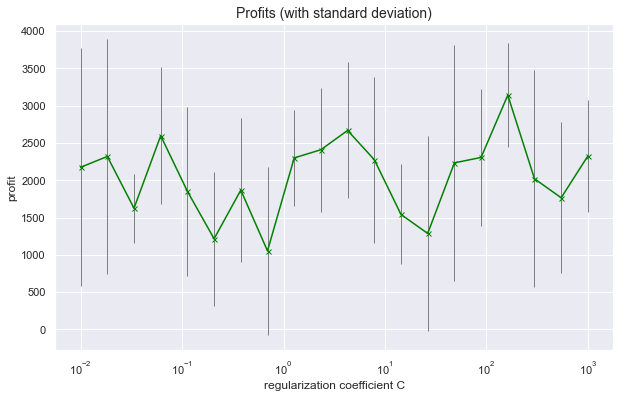

In [126]:
plt.figure(figsize=(10,6))
plt.errorbar(np.logspace(-2,3,20), mean_profits, std_profits, marker='x', color='green', ecolor='grey', elinewidth=1, ms=5)
plt.xscale('log')
plt.title('Profits (with standard deviation)', size=14)
plt.xlabel('regularization coefficient C')
plt.ylabel('profit')
plt.show()

In [128]:
print('Best regularization coefficient C: %.4f' % res_1['best_C'])
print('Max profit: %.4f' % res_1['max_profit'])

Best regularization coefficient C: 162.3777
Max profit: 3140.2109


*Как можно заметить, прибыль увеличилась на несколько сотен единиц.*

Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [129]:
for i in range(10):    # change from 6 to 10?
    res = cv_reg_by_profit(np.logspace(-2,3,20))
    print('C: %.4f, profit: %.4f' % (res['best_C'], res['max_profit']))

C: 88.5867, profit: 2482.9072
C: 88.5867, profit: 2998.4943
C: 88.5867, profit: 2717.9922
C: 7.8476, profit: 3196.7235
C: 7.8476, profit: 2495.6652
C: 0.0616, profit: 2728.1068
C: 0.0183, profit: 2888.0035
C: 0.1129, profit: 2598.3287
C: 162.3777, profit: 3089.9661
C: 2.3357, profit: 2427.0676


*В некоторых случаях находятся одинаковые коэффициенты (88.59, 7.85, 162.377). Однако нет определённой закономерности между найденными коэффициентами и полученными для них значениями прибыли (скорее всего, из-за случайности значения выручки за один звонок).*

__Задание 13 (1 балл).__ Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ *recall, т.е. полнота, важнее, поскольку для задачи нужно, чтобы модель охватила как можно больше объектов из положительного класса (интересны именно случаи, когда клиент соглашается на условия и компания получает выручку).*



Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки порога бинаризации этих вероятностей мы сможем получить какой-то выигрыш? Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот.

In [130]:
def cv_threshold_by_profit(thresholds):
    max_profit = 0
    best_threshold = None
    best_estimator = None
    profits = []
    for t in thresholds:
        profit_rand = []
        for train_index, test_index in kf.split(X_12):
            X_train_12 = X_12.loc[train_index,:]
            y_train_12 = y_12[train_index]
            X_test_12 = X_12.loc[test_index,:]
            y_test_12 = y_12[test_index]
            lr_pipeline_12_ = Pipeline([
                ('col_tf', column_transformer_12),
                ('lr', LogisticRegression(penalty='l2', max_iter=1000))
            ])
            model = lr_pipeline_12_.fit(X_train_12, y_train_12)
            y_preds = model.predict_proba(X_test_12)[:,1]
            y_preds = (y_preds > t)    # split classes by threshold
            income_ = y_test_12[y_preds == 1].sum() * np.random.uniform(0, max_income)
            expense_ = y_preds.sum() * expense_per_call
            profit_rand.append(income_ - expense_)

        profits.append(profit_rand)
        if (np.mean(profit_rand) > max_profit):
            best_threshold = t
            best_estimator = lr_pipeline_12_
            max_profit = np.mean(profit_rand)
        
    return {'best_threshold':best_threshold, 'best_estimator':best_estimator, 'max_profit':max_profit, 'profits':profits}

In [131]:
d = cv_threshold_by_profit(np.arange(0,1,0.01))

Постройте график зависимости прибыли от порога бинаризации, также отметьте на нем стандартные отклонения. Выделите наилучший порог.

[Stackoverflow: annotate maximum value](https://stackoverflow.com/questions/43374920/how-to-automatically-annotate-maximum-value-in-pyplot)

In [132]:
def annot_max(x,y, ax=None):
    xmax = x[np.argmax(y)]
    ymax = y.max()
    text= "t={:.3f}, profit={:.3f}".format(xmax, ymax)
    if not ax:
        ax=plt.gca()
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    arrowprops=dict(arrowstyle="->",connectionstyle="angle,angleA=0,angleB=60", color='black')
    kw = dict(xycoords='data',textcoords="axes fraction",
              arrowprops=arrowprops, bbox=bbox_props, ha="right", va="top")
    ax.annotate(text, xy=(xmax, ymax), xytext=(0.94,0.96), **kw)

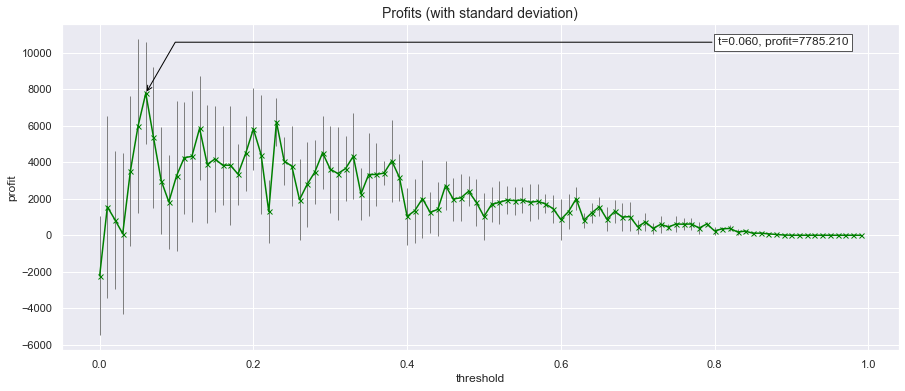

In [133]:
mean_profits_ = np.mean(d['profits'], axis=1)
std_profits_ = np.std(d['profits'], axis=1)
fig, ax = plt.subplots(figsize=(15,6))
ax.errorbar(np.arange(0,1,0.01), mean_profits_, std_profits_, marker='x', color='green', elinewidth=1, ms=5, ecolor='grey')
ax.set_title('Profits (with standard deviation)', size=14)
ax.set(xlabel='threshold', ylabel='profit')
annot_max(np.arange(0,1,0.01), mean_profits_)
plt.show()

__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

In [150]:
for i in range(5):
    res = cv_threshold_by_profit(np.arange(0,1,0.01))
    print('Threshold: %.4f, profit: %.4f' % (res['best_threshold'], res['max_profit']))

Threshold: 0.1000, profit: 9271.0989
Threshold: 0.0700, profit: 6860.0470
Threshold: 0.0700, profit: 8620.8938
Threshold: 0.0700, profit: 7391.6832
Threshold: 0.0700, profit: 7402.6898


*Значения порога получаются в пределах 0.07, возможно, потому, что при меньшем пороге значение recall выше (тогда и прибыль будет больше).*

Каковы значения precision и recall на выбранном пороге? Оцените по кросс-валидации. Также вычислите стандартное отклонение.

In [135]:
threshold = d['best_threshold']

from sklearn.metrics import recall_score, precision_score

recall_scores = []
precision_scores = []
for train_index, test_index in kf.split(X_12):
    X_train_12 = X_12.loc[train_index,:]
    y_train_12 = y_12[train_index]
    X_test_12 = X_12.loc[test_index,:]
    y_test_12 = y_12[test_index]
    lr_pipeline_12_ = Pipeline([
        ('col_tf', column_transformer_12),
        ('lr', LogisticRegression(penalty='l2', max_iter=1000))
    ])
    model = lr_pipeline_12_.fit(X_train_12, y_train_12)
    y_preds = model.predict_proba(X_test_12)[:,1]
    y_preds = (y_preds > threshold)    # split classes by threshold
    recall_scores.append(recall_score(y_test_12, y_preds))
    precision_scores.append(precision_score(y_test_12, y_preds))

In [136]:
print('Chosen threshold =', threshold)
print('Mean precision score: %.4f, standard deviation: %.4f' % (np.mean(precision_scores), np.std(precision_scores)))
print('Mean recall score: %.4f, standard deviation: %.4f' % (np.mean(recall_scores), np.std(recall_scores)))

Chosen threshold = 0.06
Mean precision score: 0.1943, standard deviation: 0.0054
Mean recall score: 0.7964, standard deviation: 0.0098


Как вы, вероятно, уже поняли, ваша модель склоняется к более высокому recall. Попробуйте оценить качество модели с помощью `PR-AUC` в зоне recall $\geq$ 0.5. Сделайте это следующим образом - выберите только те пороги, на которых достигается необходимый recall, затем интерпретируйте отсеченный в единичном квадрате прямоугольник как новый единичный квадрат и посчитайте площадь под отсеченной кривой. 

In [137]:
# ¯\_(ツ)_/¯

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ [miến gà!](https://www.hungryhuy.com/mien-ga/)